In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


<h1>4. Machine Learning Models </h1>

<h2> 4.1 Reading data from file and storing into sql table </h2>

In [0]:
#http://www.sqlitetutorial.net/sqlite-python/create-tables/
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None


def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

In [0]:
import sqlite3
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
con = sqlite3.connect('/content/drive/My Drive/Asgn/train.db')

In [0]:
read_db = 'train.db'
#conn_r = create_connection(read_db)
checkTableExists(con)


Tables in the databse:
data


1

In [0]:
data = pd.read_sql_query("SELECT * From data ORDER BY RANDOM() LIMIT 100001;", con)

In [0]:
data.head()

,index,Unnamed: 0,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,344_y,345_y,346_y,347_y,348_y,349_y,350_y,351_y,352_y,353_y,354_y,355_y,356_y,357_y,358_y,359_y,360_y,361_y,362_y,363_y,364_y,365_y,366_y,367_y,368_y,369_y,370_y,371_y,372_y,373_y,374_y,375_y,376_y,377_y,378_y,379_y,380_y,381_y,382_y,383_y
0,148326,148324.0,148324,1,0.799984000319994,0.799984000319994,0.666655555740738,0.571420408279882,0.727266115762584,0.666661111157407,0.0,1.0,1.0,11.5,83,71,66,68,0.310344827586207,4,3,57,61,11,12,6.0,23.0,0.260869565217391,7,1,2.99535025656223,81.0052576065064,72.2162759732455,127.454783678055,-16.8284819722176,79.8405883312225,-35.6265704333782,-36.1617116481066,42.3747211694717,38.8727232813835,...,-11.3156846016645,2.27614861400798,13.5685174465179,10.0108493119478,9.03498215228319,14.6791855165502,-8.22646885924041,8.19644975569099,-16.2773083597422,-4.10020682960749,7.8558311611414,-6.30888809263706,-6.92539179325104,-21.419191621244,-3.28887762874365,-20.5081413239241,-18.2814588584006,-6.89023451507092,0.595350327668712,10.9641032218933,-26.1569372117519,-0.580431875772774,4.72662079334259,4.5382681787014,5.71046382933855,14.8160029351711,-13.9409410059452,5.88404362648726,-0.366337336599827,-0.312069818377495,0.00827748328447342,13.7360498905182,7.66852301359177,-1.00631661433727,7.03801007755101,-3.91972321271896,-16.5832840998191,8.8980258256197,14.9125170409679,-0.796819280833006
1,128890,128888.0,128888,1,0.599988000239995,0.599988000239995,0.714275510349852,0.555549382784636,0.615379881693218,0.499996875019531,1.0,1.0,3.0,14.5,81,76,69,71,0.457627118644068,4,2,58,71,13,16,8.0,26.0,0.307692307692308,6,2,25.1918933391571,48.6200063228607,75.8219050168991,84.34220020473,8.0629677772522,-15.2696161568165,16.2480542063713,-58.4561445713043,17.0019124820828,20.3545722458512,...,-8.53724011778832,3.5302799269557,-22.7683596611023,13.7112737800926,28.9569245334715,-12.7405299395323,-13.2545213997364,28.2058743834496,-4.2701121121645,-2.54810556909069,9.7970820479095,13.2960404213518,7.16134133934975,-27.1752937138081,-1.90984376519918,-27.6066273543984,-13.0991953760386,24.8657997846603,16.6982342600822,-1.01564974710345,-45.6608705744147,-33.7974959164858,5.04631184786558,-9.00618724524975,19.280079767108,11.0939187407494,-1.75831251591444,21.5912123322487,-17.9849964566529,-1.89716180413961,9.52877409383655,-6.72403490543366,10.1159339249134,-11.9590798914433,-1.03050360269845,9.49347316473722,-9.74949796497822,3.1110478490591,15.7739846482873,2.74124613031745
2,11576,11574.0,11574,1,0.999980000399992,0.833319444675922,0.999980000399992,0.999980000399992,0.999990000099999,0.90908264470323,1.0,1.0,1.0,10.5,100,90,90,87,0.818181818181818,3,5,66,54,11,10,10.0,21.0,0.476190476190476,8,2,35.5868933796883,52.6990890800953,47.6210116147995,106.5530564785,-29.0741202831268,-9.76817756891251,-93.3503977060318,-60.9245547652245,47.1620235443115,19.3157760500908,...,-17.026842713356,-1.13054697960615,7.46551424264908,4.19690614938736,7.21408115327358,-6.92479808116332,-5.58771238103509,9.07521809032187,-18.1853927448392,2.56585624814033,7.70308172702789,2.87064172327518,-2.22228601574898,-21.3113708496094,-2.81284589134157,-15.7277707010508,-11.5506858229637,6.3980230987072,0.971711814403534,11.7061901148409,-12.4638404399157,1.5538858644577,4.27018736395985,3.17681342363358,7.24407380819321,-2.05362655222416,-19.5307990312576,15.3508540093899,-4.42657765932381,3.12435963749886,2.92695528268814,8.37032894045114,6.76576298475266,-2.52242068573833,9.47006590664387,-3.06361575424671,-12.6466747161467,7.88117441907525,2.53589111566544,-2.3258193731308
3,452489,272487.0,272487,1,0.999975000624984,0.799984000319994,0.999966667777741,0.49

In [0]:
# remove the first row 
data.drop(data.index[0], inplace=True)
y_true = data['is_duplicate']
data.drop(['Unnamed: 0', 'id','index','is_duplicate'], axis=1, inplace=True)

In [0]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

**Importing datasets for datapoints**

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

     |████████████████████████████████| 993kB 43.3MB/s 


In [0]:
link = 'https://drive.google.com/open?id=1LT6nzrxL57gBn-4Q7UPc_stjXRlYokHF' # The shareable link

In [0]:
df1 = pd.read_csv('/content/drive/My Drive/Asgn/df_fe_without_preprocessing_train.csv',encoding='latin-1',)

In [0]:
df1.head(5)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [0]:
df2 = pd.read_csv('/content/drive/My Drive/Asgn/nlp_features_train.csv',encoding='latin-1',)

In [0]:
df2.head(5)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,36,36,35,40,0.039216
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,46,56,0.175000


**Merging dataframes to get needed features.**

In [0]:
df1 = df1.drop(['qid1','qid2'],axis=1)


In [0]:
df2 = df2.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)

In [0]:
dfsum  = df1.merge(df2, on='id',how='left')

In [0]:
dfsum.head(5)

,id,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667
3,3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,36,36,35,40,0.039216
4,4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,46,56,0.175000


In [0]:
from sklearn.utils import resample

In [0]:
dfsum['question1'] = dfsum['question1'].apply(lambda x: str(x))
dfsum['question2'] =dfsum['question2'].apply(lambda x: str(x))
print(dfsum.shape)
dfsum.head()

(404290, 30)


,id,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667
3,3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,36,36,35,40,0.039216
4,4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,46,56,0.175000


In [0]:
df1 = df1.fillna('')
nan_rows = df1[df1.isnull().any(1)]

In [0]:
df1['question1'] = df1['question1'].apply(lambda x: str(x))
df1['question2'] = df1['question2'].apply(lambda x: str(x))

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(df1['question1']) + list(df1['question2'])

tfidf = TfidfVectorizer(lowercase=False,)
tfidf.fit_transform(questions)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [0]:
datasmpl = dfsum.sample(n=100000,random_state = 42)
datasmpl.shape

(100000, 30)

In [0]:
y = datasmpl['is_duplicate']
y.shape

(100000,)

Splitting into train and test sets

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(datasmpl, y, shuffle=True, stratify=y, test_size=0.3)

In [0]:
print("Number of data points in train set :",X_train.shape)
print("Number of data points in test set :",X_test.shape)

Number of data points in train set : (70000, 30)
Number of data points in test set : (30000, 30)


In [0]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6287857142857143 Class 1:  0.3712142857142857
---------- Distribution of output variable in train data ----------
Class 0:  0.3712 Class 1:  0.3712


# **Using TF-IDF vectors**

In [0]:
import scipy.sparse
from sklearn.feature_extraction.text import TfidfVectorizer
#question 1
tfidfvect = TfidfVectorizer(lowercase=False,max_features= 20000)
q1 = tfidfvect.fit_transform(X_train['question1'])
qts1  = tfidfvect.transform(X_test['question1'])
#question 2
q2 = tfidfvect.fit_transform(X_train['question2'])
qts2  = tfidfvect.transform(X_test['question2'])


In [0]:
print(q1.shape)
print(qts1.shape)
print(q2.shape)
print(qts2.shape)

(70000, 20000)
(30000, 20000)
(70000, 20000)
(30000, 20000)


In [0]:
#Using hstack to stack into columns
tfidftr = hstack((q1,q2))
tfidfts = hstack((qts1,qts2))

In [0]:
#Selecting features for modelling
trfeat = X_train.drop(['id','question1','question2','is_duplicate'], axis=1, inplace=False)
tsfeat = X_test.drop(['id','question1','question2','is_duplicate'], axis=1, inplace=False)

In [0]:
#Converting to sparse matrix
trsparse = scipy.sparse.csr_matrix(trfeat)
tssparse = scipy.sparse.csr_matrix(tsfeat)

In [0]:
#Stacking matrices
X_train = hstack((trsparse,tfidftr))
X_train.shape
X_test = hstack((tssparse,tfidfts))
X_test.shape

(30000, 40026)

**Applying models on dataset**

Logistic Regression

For values of alpha =  1e-05 The log loss is: 0.4129760714727073
For values of alpha =  0.0001 The log loss is: 0.4157091503680285
For values of alpha =  0.001 The log loss is: 0.4231509268265521
For values of alpha =  0.01 The log loss is: 0.4447065320990022
For values of alpha =  0.1 The log loss is: 0.4617331822379027
For values of alpha =  1 The log loss is: 0.49091976162442597
For values of alpha =  10 The log loss is: 0.5378679458860072


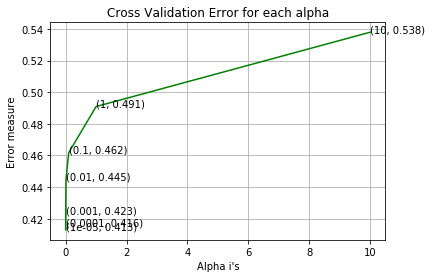

For values of best alpha =  1e-05 The train log loss is: 0.4067111963487957
For values of best alpha =  1e-05 The test log loss is: 0.41473089640205235
Total number of data points : 30000


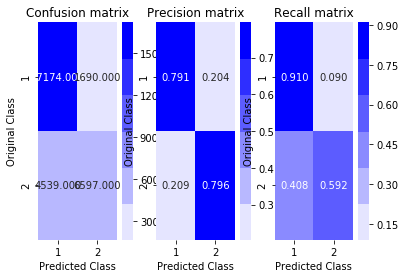

In [0]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42,class_weight='balanced')
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

SVM

For values of alpha =  1e-05 The log loss is: 0.4307726247901969
For values of alpha =  0.0001 The log loss is: 0.4474315863645944


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


For values of alpha =  0.001 The log loss is: 0.4784706232478643


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


For values of alpha =  0.01 The log loss is: 0.5203994283174603


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


For values of alpha =  0.1 The log loss is: 0.5196539134981063
For values of alpha =  1 The log loss is: 0.5602541955627278


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


For values of alpha =  10 The log loss is: 0.6595912538678794


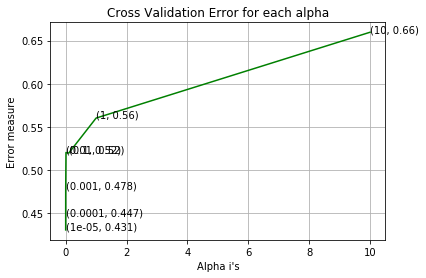

For values of best alpha =  1e-05 The train log loss is: 0.4266823820545736
For values of best alpha =  1e-05 The test log loss is: 0.43456162391938125
Total number of data points : 30000


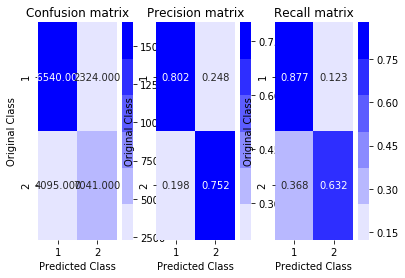

In [0]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42,class_weight='balanced')
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## **Conclusion**

The datafile is used to create a database consisting of useful features for finding similarity.TFIDF vectorisation is done finding features for the model.
SGD clasiifier is used to train models with log and hinge loss. Linear SVm and Logistic regression are applied over datast.
Since dimensionality and features are more , . Confusion mattrix is plotted.
